# Neal's funnel

This notebook introduces a toy distribution introduced by Radford Neal and is the $d+1$ dimensional,

$p(\boldsymbol{x},\nu) = \left[\prod_{i=1}^{d} \mathcal{N}(x_i|0,e^{\nu / 2})\right] \mathcal{N}(\nu|0,3),$

which has shown to cause problems for samplers owing to its "funnel" shaped geometry in the marginals $(x_i,\nu)$,

$p(x_i,\nu) = \mathcal{N}(x_i|0,e^{\nu / 2})\mathcal{N}(\nu|0,3),$

which we now plot.

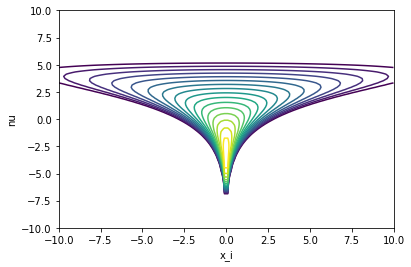

In [9]:
import os
os.chdir("..")
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt

# Create log pdf
log_pdf = pints.toy.NealsFunnelLogPDF()

# Plot marginal density
levels = np.linspace(-7, -1, 20)
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)
Z = [[log_pdf.marginal_log_pdf(i, j) for i in x] for j in y]
plt.contour(X, Y, Z, levels = levels)
plt.xlabel('x_i')
plt.ylabel('nu')
plt.show()

We can also sample independently from this toy LogPDF, and add that to the visualisation:

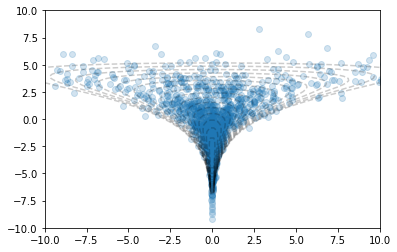

In [13]:
direct = log_pdf.sample(1500)

plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2)
plt.scatter(direct[:, 0], direct[:, 9], alpha=0.2)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()

We now try to sample from the distribution with MCMC:

In [15]:
# Create an adaptive covariance MCMC routine
x0 = np.random.uniform(-25, 25, size=(3, 10))
mcmc = pints.MCMCController(log_pdf, 3, x0, method=pints.AdaptiveCovarianceMCMC)

# Stop after 10000 iterations
mcmc.set_max_iterations(3000)

# Disable logging
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Discard warm-up
chains = [chain[1000:] for chain in chains]

Running...
Done!


The adaptive covariance fails to get into the funnel region.

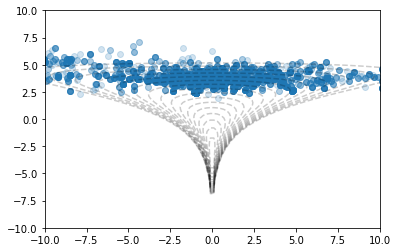

In [18]:
stacked = np.vstack(chains)
plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2)
plt.scatter(stacked[:, 0], stacked[:, 9], alpha=0.2)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()

Now check how close the result is to the expected result, using the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence), and compare this to the result from sampling directly.

In [19]:
print(log_pdf.kl_divergence(stacked))
print(log_pdf.kl_divergence(direct))

1.73329930001
0.000232900167854


Hamiltonian Monte Carlo fares much better on this curved density.

In [25]:
# Create an adaptive covariance MCMC routine
x0 = np.random.uniform(0, 10, size=(3, 10))
sigma0 = np.repeat(0.25, 10)
mcmc = pints.MCMCController(log_pdf, 3, x0, method=pints.HamiltonianMCMC, sigma0=sigma0)

# Stop after 10000 iterations
mcmc.set_max_iterations(500)

# Disable logging
# mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

chains1 = [chain[1000:] for chain in chains]
stacked = np.vstack(chains1)

print(log_pdf.kl_divergence(stacked))
print(log_pdf.kl_divergence(direct))

Running...
Using Hamiltonian Monte Carlo
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     63     0         0.333     0          0:00.1
2     123    0         0.5       0.25       0:00.2
3     183    0         0.6       0.4        0:00.4
20    1203   0.545     0.818     0.727      0:02.2
40    2403   0.595     0.833     0.619      0:04.4
60    3603   0.645     0.758     0.613      0:06.6
80    4803   0.634     0.744     0.622      0:08.8
100   6003   0.657     0.754902  0.657      0:11.1
120   7203   0.647541  0.754     0.623      0:13.3
140   8403   0.669     0.761     0.606      0:15.5
160   9603   0.673     0.741     0.617284   0:17.7
180   10803  0.687     0.725     0.61       0:20.0
200   12003  0.693     0.713     0.619      0:22.2
220   13203  0.698     0.716     0.635      0:24.4
240   14403  0.698     0.711     0.624      0:26.6
260   15603  0.691     0.706     0.634     

/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


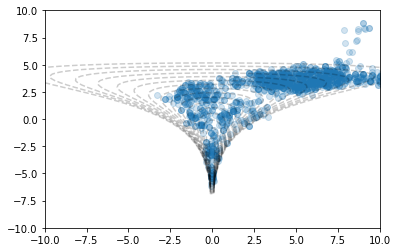

In [26]:
stacked = np.vstack(chains)
plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2)
plt.scatter(stacked[:, 0], stacked[:, 9], alpha=0.2)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()

Visualising the true marginal distribution and the sampled marginal.

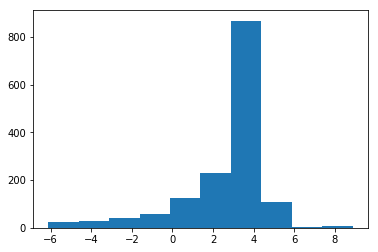

In [35]:
nu = np.linspace(-10, 10, 100)
pdf = scipy.stats.no

plt.hist(stacked[:, 9], density=True)
plt.plot()
plt.show()

Visualising the path of one of the chains the sampler struggles to explore both the neck and the outside region efficiently.

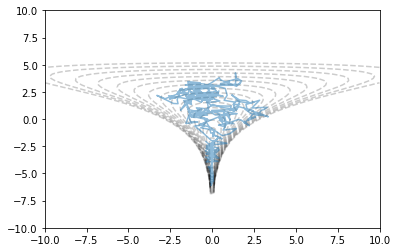

In [33]:
divergent_transitions = mcmc.samplers()[0].divergent_iterations()
plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2)
plt.plot(chains[0][:, 0], chains[0][:, 9], alpha=0.5)
plt.scatter(chains[0][divergent_transitions, 0], chains[0][divergent_transitions, 1], color='red')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()